In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import pwlf
from scipy.signal import savgol_filter

## Load data and process time

In [3]:
df = pd.read_csv('/scratch/ab9738/traffic/data/NYCDOT/toi_file.csv')

In [4]:
timestamp = df['DATA_AS_OF']
timestamp = pd.to_datetime(timestamp, format="%m/%d/%Y %I:%M:%S %p")
df['DATA_AS_OF'] = timestamp

Remove cases when speed is 0 since it means data is not available.

In [5]:
df = df[df.SPEED != 0]

In [6]:
road_ids = df['ID'].unique()

In [7]:
len(road_ids)

122

In [8]:
df = df.set_index('ID')

Sort by date

In [9]:
df = df.sort_values('DATA_AS_OF')

In [10]:
df = df[['SPEED','DATA_AS_OF']]

## Visualize speed wrt time

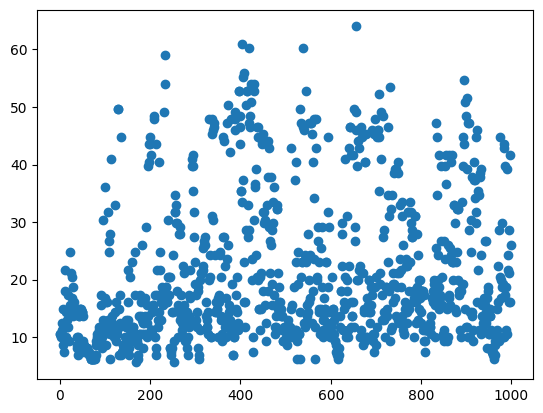

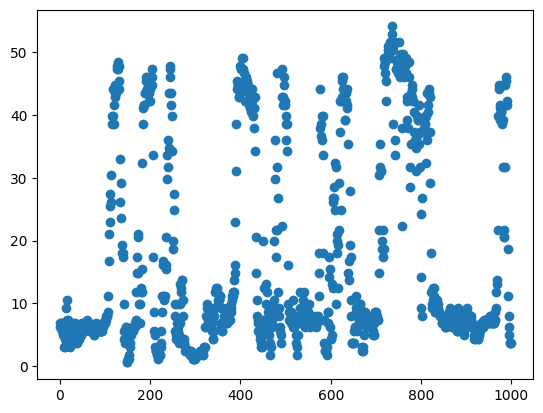

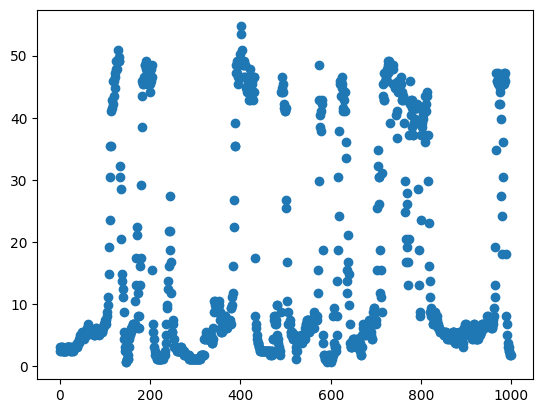

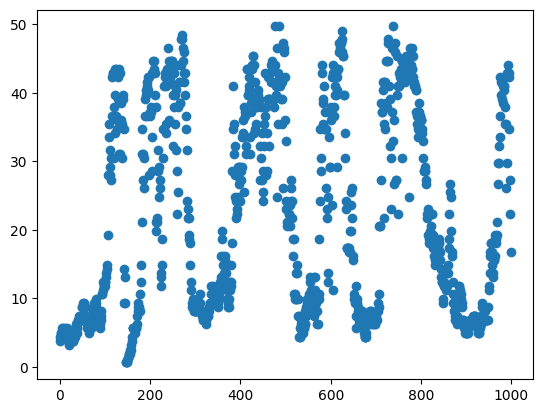

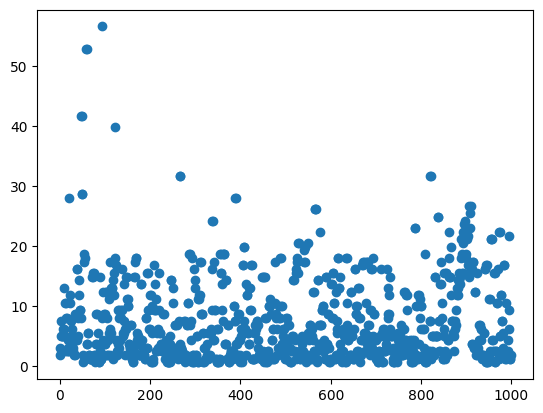

In [11]:
for ids in road_ids[:5]:
    speed_arr = df.loc[ids]['SPEED'].to_numpy()
    plt.figure()
    plt.scatter(np.arange(1000), speed_arr[:1000])

## Generate hourly average

In [12]:
df_hourly = deepcopy(df)

In [13]:
stack = []
for ids in road_ids:
    df_ = df_hourly.loc[ids]
    for i in range(len(df_)):
        dt = pd.Timestamp(df_['DATA_AS_OF'].values[i])
        dt = dt + pd.DateOffset(hours=1)
        dt = dt.replace(minute=0,second=0)
        df_.iloc[i,df_.columns.get_loc('DATA_AS_OF')] = dt
    df_ = df_.groupby('DATA_AS_OF').mean()
    df_['ID'] = np.ones(len(df_)).astype(int)*ids
    df_ = df_.reset_index()
    df_ = df_.set_index(['ID'])
    stack.append(df_)
df_hourly = pd.concat(stack)

In [14]:
df_hourly

,DATA_AS_OF,SPEED
ID,,
448,2022-05-19 13:00:00,11.645833
448,2022-05-19 14:00:00,14.494167
448,2022-05-19 15:00:00,16.307500
448,2022-05-19 16:00:00,12.010000
448,2022-05-19 17:00:00,10.904444
...,...,...
440,2022-06-13 04:00:00,55.038333
440,2022-06-13 05:00:00,54.520833
440,2022-06-13 06:00:00,56.282500


## Generate speed curves for visualization

/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


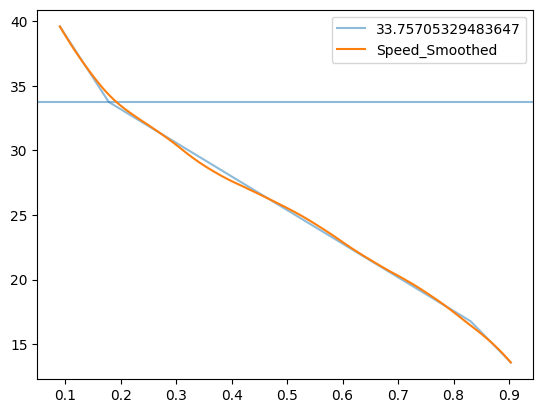

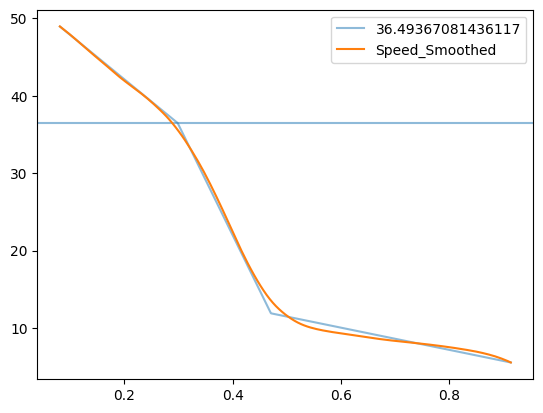

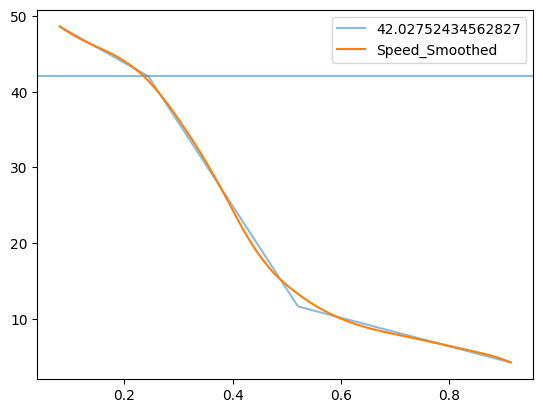

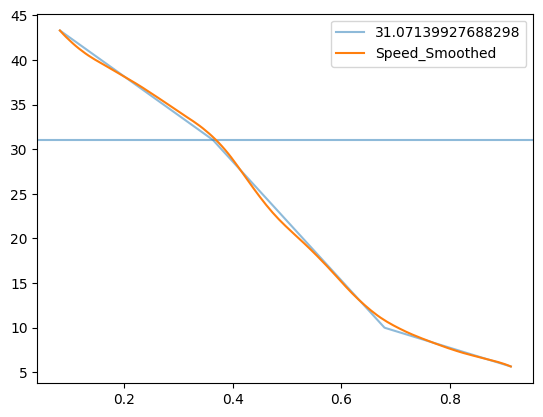

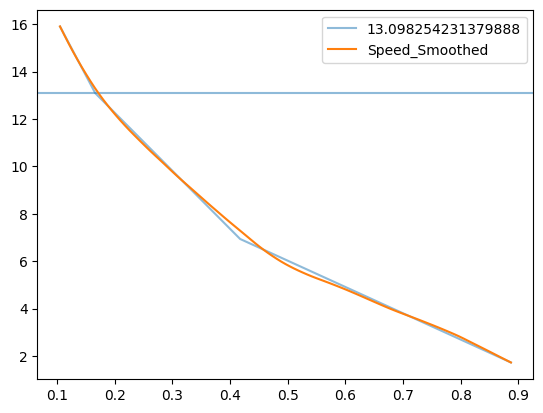

In [15]:
for ids in road_ids[:5]:
    series = df_hourly.loc[ids]['SPEED'].to_numpy()
    
    indices = np.cumsum(np.random.poisson(8, int(len(series)/8)))
    indices = indices[indices<len(series)]
    speed_sample = series[indices]
    # speed_sample = speed_sample*(1.6/3.6)
    speed_sample.sort()
    speed_sample = speed_sample[::-1]
    
    ind = np.arange(len(speed_sample))
    ind = ind/len(speed_sample)
    
    kernel_size = 15
    kernel = np.ones(kernel_size) / kernel_size
    smoothed_sample = np.convolve(speed_sample, kernel, mode='valid')
    smoothed_sample = np.convolve(smoothed_sample, kernel, mode='valid')
    offset = int((len(ind) - len(smoothed_sample)) / 2)
    ind = ind[offset:-offset]
    
    pwlf_func = pwlf.PiecewiseLinFit(ind, smoothed_sample)
    breaks = pwlf_func.fit(3, x_c=[ind[0],ind[-1]], y_c=[smoothed_sample[0],smoothed_sample[-1]])
    x_lin = np.linspace(ind[0], ind[-1], 1000)
    y_lin = pwlf_func.predict(x_lin)
    s_vals = pwlf_func.predict(breaks)
    s1, s2 = s_vals[2], s_vals[1]
    
    fig = plt.figure()
    plt.plot(x_lin, y_lin, alpha=0.5)
    plt.axhline(s2, label=str(s2), alpha=0.5)
    plt.plot(ind, smoothed_sample, label='Speed_Smoothed')
    plt.legend()

In [16]:
np.random.seed(17)

## Correlations between speed based jam and sudden jam

In [17]:
jams_df = pd.DataFrame(columns=['ID', 'Jam_Time', 'Jam_Speed', 'Jam_Deceleration'])
speed_df = pd.DataFrame(columns=['ID', 's1', 's2', 'max_speed', 'min_speed'])
total_jams = {}
for ids in road_ids:
    series = df_hourly.loc[ids]['SPEED'].to_numpy()
    indices = np.cumsum(np.random.poisson(8, int(len(series)/8)))
    indices = indices[indices<len(series)]
    speed_sample = series[indices]
    speed_sample.sort()
    speed_sample = speed_sample[::-1]

    if(len(speed_sample)>20):
        ind = np.arange(len(speed_sample))
        ind = ind/len(speed_sample)

        kernel_size = 15
        kernel = np.ones(kernel_size) / kernel_size
        smoothed_sample = np.convolve(speed_sample, kernel, mode='valid')
        smoothed_sample = np.convolve(smoothed_sample, kernel, mode='valid')
        offset = int((len(ind) - len(smoothed_sample)) / 2)
        ind = ind[offset:-offset]

        pwlf_func = pwlf.PiecewiseLinFit(ind, smoothed_sample, seed=17)
        breaks = pwlf_func.fit(3, x_c=[ind[0],ind[-1]], y_c=[smoothed_sample[0],smoothed_sample[-1]])
        x_lin = np.linspace(ind[0], ind[-1], 1000)
        y_lin = pwlf_func.predict(x_lin)
        s_vals = pwlf_func.predict(breaks)
        s1, s2 = s_vals[2], s_vals[1]
        speed_df.loc[len(speed_df)] = [ids, s1, s2, max(series), min(series)]

        jam_th = s1# jam_th = (s1+s2)/4.0
        df_ = df_hourly.loc[ids]
        df_ = df_[df_['SPEED'].between(0,jam_th)]
        if(len(df_)):
            df_ = df_.reset_index()
            df_copy_ = deepcopy(df_)
            i = 1
            while(i != len(df_)):
                if(df_.iloc[-i]['DATA_AS_OF']-pd.Timedelta(hours=1)==df_.iloc[-i-1]['DATA_AS_OF']):
                    df_copy_ = df_copy_.drop(len(df_)-i)
                i = i+1
            df_copy_ = df_copy_.set_index('ID')
            df_ = df_copy_
            num_jams = len(df_)
            total_jams[ids] = num_jams
            times = df.loc[ids]['DATA_AS_OF']
            times_unix = (times - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
            grad = np.gradient(df.loc[ids]['SPEED'].to_numpy()*(16/36.0),times_unix)
            avg_grad = np.mean(np.absolute(grad))
            print(avg_grad)
            if(num_jams):
                for i in range(num_jams):
                    ts_hour = df_.iloc[i]['DATA_AS_OF']               
                    df_minute_ = df.loc[ids][df.loc[ids]['DATA_AS_OF'].between((ts_hour-pd.Timedelta(hours=1)), ts_hour)]
                    if(len(df_minute_)>1):
                        i_begin = np.where(times==df_minute_.iloc[0]['DATA_AS_OF'])[0][0]
                        i_end = np.where(times==df_minute_.iloc[-1]['DATA_AS_OF'])[0][0]
                        grad_ = grad[i_begin:i_end+1]
                        sj_exists = 0
                        for j in range(1,len(grad_)+1):
                            if(grad_[-j]<(-0.002)):
                                # print(grad_[-j])
                                sj_exists = 1
                                break
                        if(sj_exists):
                            sp = df_minute_.iloc[-j]['SPEED']
                            ts = df_minute_.iloc[-j]['DATA_AS_OF']
                            dec = grad_[-j]
                            # print(ids, ts, sp, dec)
                            jams_df.loc[len(jams_df)] = [ids, ts, sp, dec]

/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.008125216382154974


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0023179572797964463


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.002138055109184695


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0026002012551563218


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0024016395489477723


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0029983460759592036


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.00185395286662534


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0021001291325322808


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.002432938749607779


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0023426176365179993


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.00387417841438967


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=1.41591e-17): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0024950034003691462


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0027809994296258893


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.011843572062378108


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0030526255139346013


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.01003468964547246


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0029749991847582502


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0028983073945248526


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=3.00903e-17): result may not be accurate.
  beta_prime = linalg.solve(K, z)


0.005139396617826862


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0022566671587114025


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.004505398882735706


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0016023945464074378


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=1.0495e-17): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.002322949778532245


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0023825058848172377


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.001928092309040576


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.003719286399912774


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=9.52362e-18): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.004081940208417325


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0027278831885062327


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0022886237372426875


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=1.31929e-35): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0011079026271671208


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0023043296352316905


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.003670890676246352


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0025261081327615947


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0025188747859346662


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.003846755358451983


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0018186694196602408


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0019132488084679352


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0014972156989580064


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0022305421072930593


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=2.97384e-18): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=3.0982e-18): result may not be accurate.
  beta_prime = linalg.solve(K, z)


0.0014365959096647796


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.005390326108186773


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.001539981703964303


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=1.30755e-17): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0035709743510081095


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.002989253216175344


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.003005126608594336


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=9.14642e-18): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0018123770621939646


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.002765808525922308


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0024550668352514952


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0026609112190701108


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.002452648659010815


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0024518972929571214


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0023566820474548206


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=5.73921e-19): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0025922904015294934


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.001843523274470005


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.002263989678252536


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=1.30066e-18): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=6.7908e-39): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=3.09883e-39): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=6.65661e-41): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=2.50421e-40): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traff

0.00177852719114174


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0018779631785416802


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=2.44489e-17): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=1.86856e-17): result may not be accurate.
  beta_prime = linalg.solve(K, z)


0.004822832993335138


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0019367037188371197


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=1.30066e-18): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=4.0784e-40): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=3.97922e-18): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=3.88101e-24): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=2.74983e-40): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traff

0.0009588846680000511


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.004936792161769884


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=4.7839e-20): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=7.47241e-22): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=3.96881e-20): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=3.38187e-20): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=7.6132e-22): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffi

0.0014858791165365086


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.009926331468098855


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.00993135150769543


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=4.69787e-17): result may not be accurate.
  beta_prime = linalg.solve(K, z)


0.0027516478201755684


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.002643226880079426


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.004583768393423536


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0026577856043167878


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=5.42382e-18): result may not be accurate.
  beta_prime = linalg.solve(K, z)


0.002659735519213759


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0017897979946712576


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.008256165929223609


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.008273229995892556


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.002652989831407545


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0026659297737220543


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.002729975963240491


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.00284276862929079


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0027456152712034814


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0027507645254984227


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.001352325702361941


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0014879600014185085


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=1.04302e-18): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0023876314342586415


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.006091685301117505


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0024703994295972986


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0022016331703000685


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.00499018859137174


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=7.25007e-18): result may not be accurate.
  beta_prime = linalg.solve(K, z)


0.003770894318043075


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0029017302819220685


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=3.30064e-17): result may not be accurate.
  beta_prime = linalg.solve(K, z)


0.0035742514112671797


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.002883850740781634


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0038845146549583262


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0008813443749275707


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0038011996864024344


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0013434999210016182


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.005214824065170319


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=1.31929e-35): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0016750625546701249


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0023737021046557985


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.001918233568633515


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=3.49561e-17): result may not be accurate.
  beta_prime = linalg.solve(K, z)


0.003236484745312365


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.003509869684406108


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0025021793903481407


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.001721511331389129


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0022687186683952518


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0021449769151642355


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.003227827183726639


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.002369769390793704


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0029725087976735756
0.002827330339469218


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=9.41364e-18): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.002083994759726842


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=1.22467e-18): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=4.50432e-23): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=7.28892e-23): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=4.04573e-18): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=3.28921e-42): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traf

0.0017574299744965972


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=1.92895e-17): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0023818998391195037


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=8.483e-18): result may not be accurate.
  beta_prime = linalg.solve(K, z)


0.0024665607248801915


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=2.00413e-21): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=4.20089e-19): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=8.81466e-38): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=5.91157e-19): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=2.07056e-22): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traf

4.679098593368798e-05


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.002208005849429737


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=1.27003e-17): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.004394347479531524


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=1.26007e-18): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=6.27471e-19): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=1.30474e-18): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=1.1425e-39): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.005691283262392251


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=1.26007e-18): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=1.39705e-18): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=1.73453e-18): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=3.03922e-18): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


0.0038266716224957652


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=1.50977e-18): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=4.00362e-22): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=1.40701e-36): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=5.97213e-21): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=1.16001e-21): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traf

0.00215159511613989
0.0016041695635916754
0.0015809982979624116


/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=1.03115e-18): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=7.2039e-22): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=2.34116e-22): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=9.30658e-19): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traffic/env/lib/python3.9/site-packages/pwlf/pwlf.py:1579: LinAlgWarning: Ill-conditioned matrix (rcond=1.00256e-22): result may not be accurate.
  beta_prime = linalg.solve(K, z)
/scratch/ab9738/traff

In [18]:
len(jams_df)

9926

In [19]:
np.array(list(total_jams.values())).sum()

11997

In [20]:
len(jams_df)/np.array(list(total_jams.values())).sum()

0.8273735100441777

In [20]:
jams_df

,ID,Jam_Time,Jam_Speed,Jam_Deceleration
0,448,2022-05-21 07:59:03,5.59,-0.002485
1,448,2022-06-07 21:04:04,10.56,-0.020193
2,448,2022-06-21 16:28:03,8.69,-0.002763
3,448,2022-06-22 16:28:03,8.69,-0.002304
4,448,2022-06-25 23:09:04,13.67,-0.002299
...,...,...,...,...
4052,257,2022-08-04 23:44:11,6.83,-0.004142
4053,257,2022-08-07 02:44:11,3.72,-0.004114
4054,257,2022-08-07 14:59:10,11.18,-0.011970
4055,257,2022-08-07 19:53:12,23.61,-0.009643


In [21]:
speed_df

,ID,s1,s2,max_speed,min_speed
0,448.0,18.675625,27.338643,56.540000,6.210000
1,190.0,11.568303,43.682771,54.830833,0.620000
2,191.0,11.762412,43.243538,55.712500,0.620000
3,344.0,8.975562,31.770748,51.725000,0.620000
4,186.0,5.026608,10.449336,56.540000,0.620000
...,...,...,...,...,...
116,110.0,21.209464,24.510899,59.958333,35.983333
117,338.0,13.786291,13.786291,45.407500,3.825000
118,433.0,27.687739,27.687739,59.958333,9.688000
119,437.0,26.481113,26.481113,56.903333,26.218000


In [22]:
loc_ids = np.intersect1d(jams_df['ID'].to_numpy(), speed_df['ID'].to_numpy().astype(int))

In [23]:
jams_df = jams_df.set_index('ID')
speed_df = speed_df.set_index('ID')

In [24]:
jams_df = jams_df.loc[loc_ids]
speed_df = speed_df.loc[loc_ids]

In [28]:
jam_freq = jams_df.groupby('ID').size().to_numpy()

In [29]:
s1 = speed_df['s1'].to_numpy()

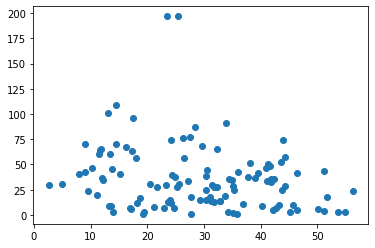

In [30]:
plt.scatter(s1, jam_freq)